# Bioethanol production in Brazil

### Downloading the data

In [1]:
# Un-comment to download spreadsheets to data folder
#import requests, zipfile, io
#r = requests.get('https://www.gov.br/anp/pt-br/assuntos/producao-e-fornecimento-de-biocombustiveis/etanol/arquivos-etanol/pb-da-etanol.zip')
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall(path='./data/')

### Reading the data

In [2]:
from pathlib import Path
import csv

from jedi.inference.utils import to_list

In [3]:
# File containing production capacity per plant site
path = Path('./data/Etanol_DadosAbertos_CSV_Capacidade.csv')
lines = path.read_text(encoding='utf-8').splitlines()

reader = csv.reader(lines)
header_row = next(reader)

In [4]:
print("Column names:")
for i, name in enumerate(header_row):
    print(f"{i}: {name}")

Column names:
0: ﻿Mês/Ano
1: Razão Social
2: CNPJ
3: Região
4: Estado
5: Município
6: Capacidade Produção Etanol Anidro (m³/d)
7: Capacidade Produção Etanol Hidratado (m³/d)


Note: A CNPJ, or Cadastro Nacional de Pessoa Jurídica, is a unique tax identification number given to entities such as companies, partnerships, foundations and in this case, plant sites. Each plant site has its own unique CNPJ. This means that a company with multiple plants will have multiple CNPJs with a different number for each site.

In [5]:
import pandas as pd

In [6]:
date_format = '%m/%Y'

In [7]:
dates = []
names = []
cnpjs = []
states = []
capacities_anhydrous = []
capacities_hydrous = []


for row in reader:
    date = pd.to_datetime(row[0], format=date_format)
    name = row[1]
    cnpj = int(row[2])
    state = row[4]
    capacity_anhydrous = int(row[6])
    capacity_hydrous = int(row[7])

    dates.append(date)
    names.append(name)
    cnpjs.append(cnpj)
    states.append(state)
    capacities_anhydrous.append(capacity_anhydrous)
    capacities_hydrous.append(capacity_hydrous)

In [8]:
df = pd.DataFrame({'date': dates,
                   'name': names,
                   'cnpj': cnpjs,
                   'state': states,
                   'capacity_hydrous': capacities_hydrous,
                   'capacity_anhydrous': capacities_anhydrous})

In [9]:
df.head()

date                                               name          cnpj  \
0 2024-11-01                            CARAMURU ALIMENTOS  S/A   80671002668   
1 2024-11-01  DESTILARIA DE ÁLCOOL LIBRA LTDA - EM RECUPERAÇ...  297598000122   
2 2024-11-01            CENTRAL ENERGETICA VALE DO SAPUCAI LTDA  372496000124   
3 2024-11-01  DENUSA DESTILARIA NOVA UNIAO S/A - EM RECUPERA...  595322000120   
4 2024-11-01                    SANTA CRUZ ACUCAR E ALCOOL LTDA  738822000255   

         state  capacity_hydrous  capacity_anhydrous  
0  Mato Grosso                50                   0  
1  Mato Grosso               600                 600  
2    São Paulo               900                 517  
3        Goiás               650                 450  
4        Bahia               240                 200

### Exploring the data

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def get_most_recent_record(df,cnpj):
    return df[df['cnpj']==cnpj].to_dict('records')[0]

In [12]:
def get_subset_for_last_records_of_the_year(df,year):

    df_subset = df[(df['date'].dt.year > year-1) & (df['date'].dt.year < year+1)]
    unique_cnpj_list = df_subset['cnpj'].unique().tolist()

    for cnpj in unique_cnpj_list:
        date = get_most_recent_record(df_subset,cnpj)['date']
        df_subset = df_subset[~((df_subset['date']!=date) & (df_subset['cnpj']==cnpj))]

    return df_subset

In [13]:
def get_label_colors(bar_labels):

    bar_colors = []

    for label in bar_labels:
        if 'INPASA' in label:
            bar_colors.append('tab:red')
        elif 'FS ' in label:
            bar_colors.append('tab:blue')
        elif 'RAIZEN' in label:
            bar_colors.append('tab:orange')
        elif 'SAO MARTINHO' in label:
            bar_colors.append('tab:olive')
        elif 'TROPICAL' in label:
            bar_colors.append('tab:purple')
        elif 'ATVOS' in label:
            bar_colors.append('tab:green')
        else:
            bar_colors.append('tab:gray')

    return bar_colors

In [14]:
def subplot_bar_chart_capacities(ax,col_name,df,Nvals):

    xvals = np.arange(1,Nvals+1,1)
    yvals = df.sort_values(by=[col_name], ascending=False)[col_name].head(Nvals)

    bar_labels = get_labels(df,col_name,Nvals)
    bar_colors = get_label_colors(bar_labels)

    bar_chart = ax.bar(xvals , yvals, label = bar_labels, color = bar_colors)
    ax.bar_label(bar_chart, label_type='center')
    ax.legend(title='Key',fontsize=8)
    ax.set_title(col_name.replace('_',' '),fontsize=10)
    ax.set_xticks(xvals)
    ax.set_xlabel('Rank', fontsize=14)
    ax.set_ylabel('Production capacity (m³/day)', fontsize=14)


In [15]:
def get_labels(df, col_name, Nvals):

    bar_labels = df.sort_values(by=[col_name], ascending=False)['name'].head(Nvals).tolist()

    labels = []
    for i, name in enumerate(bar_labels,start=1):
        labels.append(f"{i}: {name}")

    return labels

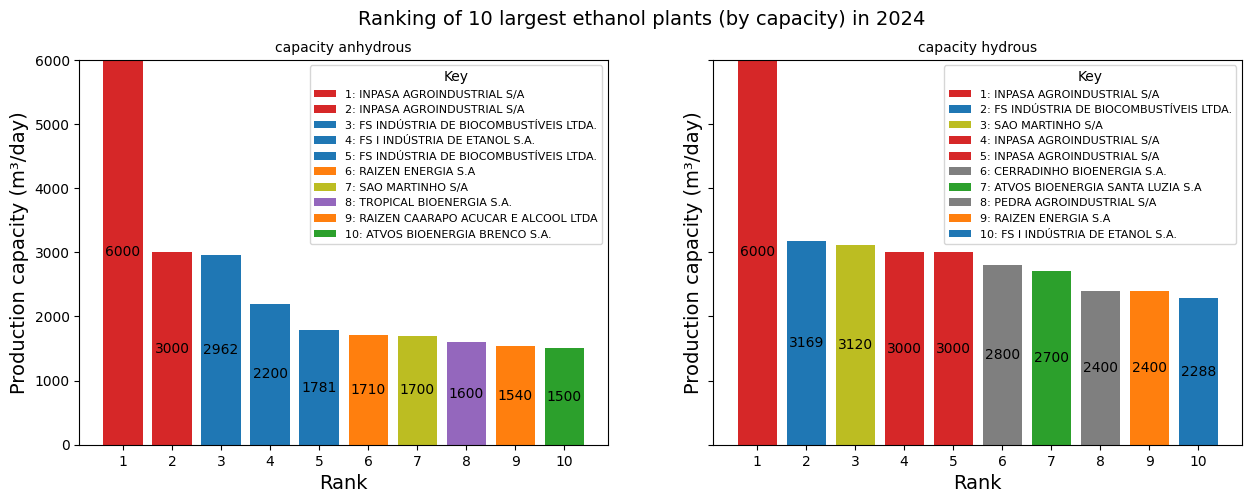

In [16]:
# Define year and top Nvals number of plants to rank
year = 2024
Nvals = 10

# Filters data for specified year
df_year = get_subset_for_last_records_of_the_year(df,year)

# Plots 2 bar charts side by side for hydrous and anhydrous ethanol
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
fig.suptitle(f"Ranking of {Nvals} largest ethanol plants (by capacity) in {year}", fontsize=14)
subplot_bar_chart_capacities(ax1,'capacity_anhydrous',df_year,Nvals)
subplot_bar_chart_capacities(ax2,'capacity_hydrous',df_year,Nvals)
plt.ylim(0, 6000)
plt.show()

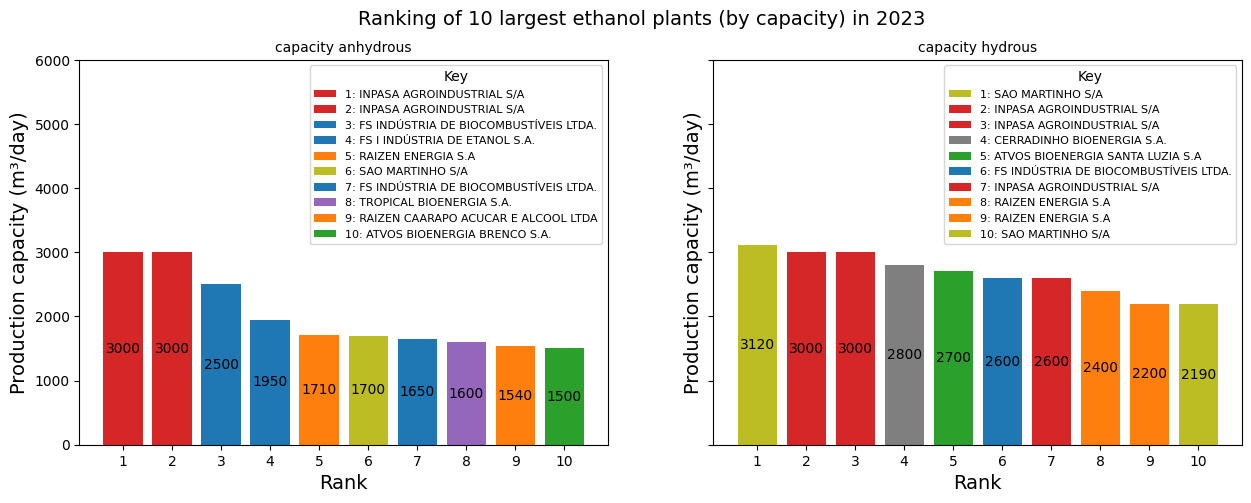

In [17]:
# Define year and top Nvals number of plants to rank
year = 2023
Nvals = 10

# Filters data for specified year
df_year = get_subset_for_last_records_of_the_year(df,year)

# Plots 2 bar charts side by side for hydrous and anhydrous ethanol
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
fig.suptitle(f"Ranking of {Nvals} largest ethanol plants (by capacity) in {year}", fontsize=14)
subplot_bar_chart_capacities(ax1,'capacity_anhydrous',df_year,Nvals)
subplot_bar_chart_capacities(ax2,'capacity_hydrous',df_year,Nvals)
plt.ylim(0, 6000)
plt.show()

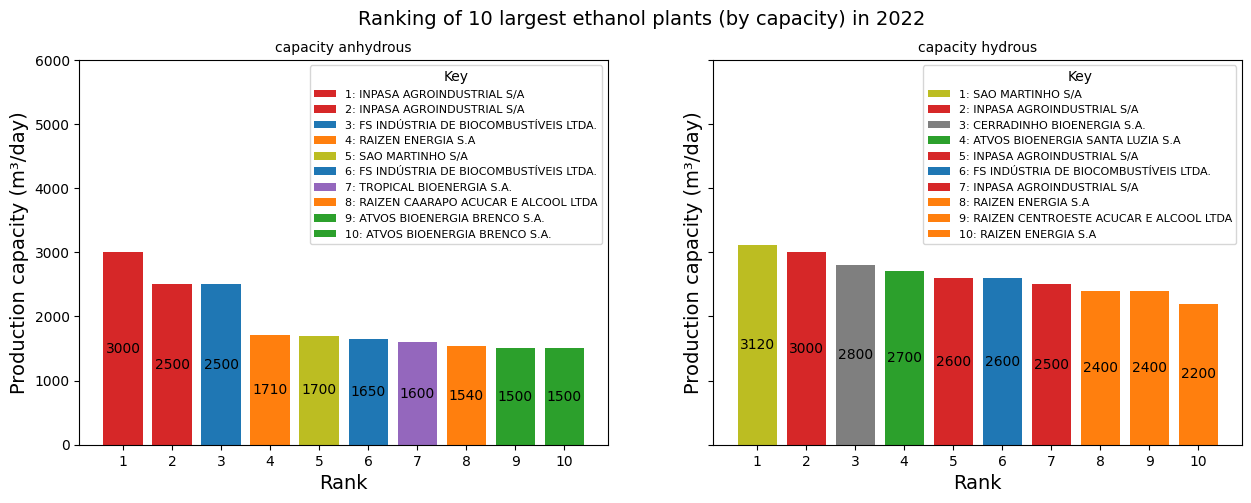

In [18]:
# Define year and top Nvals number of plants to rank
year = 2022
Nvals = 10

# Filters data for specified year
df_year = get_subset_for_last_records_of_the_year(df,year)

# Plots 2 bar charts side by side for hydrous and anhydrous ethanol
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
fig.suptitle(f"Ranking of {Nvals} largest ethanol plants (by capacity) in {year}", fontsize=14)
subplot_bar_chart_capacities(ax1,'capacity_anhydrous',df_year,Nvals)
subplot_bar_chart_capacities(ax2,'capacity_hydrous',df_year,Nvals)
plt.ylim(0, 6000)
plt.show()

### Create dataframe for top N plants over a given period

In [19]:
# Define year and top Nvals number of plants to rank
Nvals = 5
year_start = 2020
year_end = 2024

In [20]:
# merge data from over the years into a single dataframe
for year in range(year_start,year_end+1):

    # Filters data for specified year
    df_year = get_subset_for_last_records_of_the_year(df,year)
    N = df_year.index.size

    col_name = 'capacity_hydrous'
    df_hydrous_temp = df_year.sort_values(by=[col_name], ascending=False)
    df_hydrous_temp.drop(['date','state','capacity_anhydrous'], axis=1, inplace=True)
    df_hydrous_temp.rename(columns={'capacity_hydrous':str(year)}, inplace=True)
    df_hydrous_temp  = df_hydrous_temp.set_index(np.arange(N)).head(Nvals)

    if 'df_hydrous' in locals():
        df_hydrous = pd.merge(df_hydrous, df_hydrous_temp[['cnpj',str(year)]], how='outer', on='cnpj')
    else:
        df_hydrous = df_hydrous_temp


In [21]:
# fills in NaN values
for pos in range(len(df_hydrous)):
    empty_field = df_hydrous.iloc[pos].isnull()

    for field in df_hydrous.columns:
        if empty_field[field]:
            if field=='name':
                if empty_field['name']:
                    df_year = get_subset_for_last_records_of_the_year(df,year_end)
                    cnpj = df_hydrous.iloc[pos]['cnpj']
                    name = df_year.iloc[df_year[df_year['cnpj']==cnpj].index.tolist()[0]]['name']
                    df_hydrous.at[pos,'name'] = name
            else:
                df_year = get_subset_for_last_records_of_the_year(df,int(field))
                if df_year[ df_year['cnpj'] == df_hydrous.iloc[pos]['cnpj'] ].size == 0:
                    df_hydrous.at[pos,field] = 0
                else:
                    record = df_year[ df_year['cnpj'] == df_hydrous.iloc[pos]['cnpj'] ]
                    df_hydrous.at[pos,field] = record.loc[record['capacity_hydrous'].index.tolist()[0]]['capacity_hydrous']

In [22]:
# Sort by capacity in the most recent year
N = df_hydrous.index.size
df_hydrous = df_hydrous.sort_values(by=[str(year_end)], ascending=False).set_index(np.arange(N))
df_hydrous

name            cnpj    2020    2021  \
0               INPASA AGROINDUSTRIAL S/A  29316596000115  1500.0  3000.0   
1   FS INDÚSTRIA DE BIOCOMBUSTÍVEIS LTDA.  20003699000231  1560.0  2600.0   
2                        SAO MARTINHO S/A  51466860006278  3120.0  3120.0   
3               INPASA AGROINDUSTRIAL S/A  29316596000468     0.0  2600.0   
4               INPASA AGROINDUSTRIAL S/A  29316596000204     0.0     0.0   
5              CERRADINHO BIOENERGIA S.A.   8322396000103  2800.0  2800.0   
6        ATVOS BIOENERGIA SANTA LUZIA S.A   8906558000142  2700.0  2700.0   
7                      RAIZEN ENERGIA S.A   8070508000330  2200.0  2200.0   
8  RAIZEN CENTROESTE ACUCAR E ALCOOL LTDA   8619844000399  2400.0  2400.0   

     2022    2023    2024  
0  3000.0  3000.0  6000.0  
1  2600.0  2600.0  3169.0  
2  3120.0  3120.0  3120.0  
3  2600.0  2600.0  3000.0  
4  2500.0  3000.0  3000.0  
5  2800.0  2800.0  2800.0  
6  2700.0  2700.0  2700.0  
7  2200.0  2200.0  2200.0  
8  2400.0     0.0     0.0

# Ribbon chart
Adapted from https://www.kaggle.com/code/abhinavkum/ribbon-chart-in-plotly/notebook

### Creating dataframe for ribbon chart

In [23]:
ribbon_chart_df = df_hydrous[['name', 'cnpj']]
ribbon_chart_df

name            cnpj
0               INPASA AGROINDUSTRIAL S/A  29316596000115
1   FS INDÚSTRIA DE BIOCOMBUSTÍVEIS LTDA.  20003699000231
2                        SAO MARTINHO S/A  51466860006278
3               INPASA AGROINDUSTRIAL S/A  29316596000468
4               INPASA AGROINDUSTRIAL S/A  29316596000204
5              CERRADINHO BIOENERGIA S.A.   8322396000103
6        ATVOS BIOENERGIA SANTA LUZIA S.A   8906558000142
7                      RAIZEN ENERGIA S.A   8070508000330
8  RAIZEN CENTROESTE ACUCAR E ALCOOL LTDA   8619844000399

In [24]:
years = df_hydrous.columns.tolist()[2:]

In [25]:
for i, col in enumerate(years):

    ch1 = df_hydrous.loc[:,['cnpj',col]]
    ch1.sort_values(str(col), inplace=True)
    ch1[f'y{i}_upper'] = ch1[col].cumsum()
    ch1[f'y{i}_lower'] = ch1[f'y{i}_upper'].shift(1)
    ch1 = ch1.fillna(0)
    ch1[f'y{i}'] = ch1.apply(lambda x: (x[f'y{i}_upper'] + x[f'y{i}_lower'])/2, axis=1)
    ribbon_chart_df = ribbon_chart_df.merge(ch1.iloc[:, [0, 2, 3, 4]], on='cnpj')

ribbon_chart_df

name            cnpj  y0_upper  y0_lower  \
0               INPASA AGROINDUSTRIAL S/A  29316596000115    1500.0       0.0   
1   FS INDÚSTRIA DE BIOCOMBUSTÍVEIS LTDA.  20003699000231    3060.0    1500.0   
2                        SAO MARTINHO S/A  51466860006278   16280.0   13160.0   
3               INPASA AGROINDUSTRIAL S/A  29316596000468       0.0       0.0   
4               INPASA AGROINDUSTRIAL S/A  29316596000204       0.0       0.0   
5              CERRADINHO BIOENERGIA S.A.   8322396000103   13160.0   10360.0   
6        ATVOS BIOENERGIA SANTA LUZIA S.A   8906558000142   10360.0    7660.0   
7                      RAIZEN ENERGIA S.A   8070508000330    5260.0    3060.0   
8  RAIZEN CENTROESTE ACUCAR E ALCOOL LTDA   8619844000399    7660.0    5260.0   

        y0  y1_upper  y1_lower       y1  y2_upper  y2_lower       y2  \
0    750.0   18300.0   15300.0  16800.0   20800.0   17800.0  19300.0   
1   2280.0    7200.0    4600.0   5900.0    9700.0    7100.0   8400.0   
2  14720.0   21420.0   18300.0  19860.0   23920.0   20800.0  22360.0   
3      0.0    9800.0    7200.0   8500.0   12300.0    9700.0  11000.0   
4      0.0       0.0       0.0      0.0    7100.0    4600.0   5850.0   
5  11760.0   15300.0   12500.0  13900.0   17800.0   15000.0  16400.0   
6   9010.0   12500.0    9800.0  11150.0   15000.0   12300.0  13650.0   
7   4160.0    2200.0       0.0   1100.0    2200.0       0.0   1100.0   
8   6460.0    4600.0    2200.0   3400.0    4600.0    2200.0   3400.0   

   y3_upper  y3_lower       y3  y4_upper  y4_lower       y4  
0   18900.0   15900.0  17400.0   25989.0   19989.0  22989.0  
1    7400.0    4800.0   6100.0   19989.0   16820.0  18404.5  
2   22020.0   18900.0  20460.0   16820.0   13700.0  15260.0  
3    4800.0    2200.0   3500.0   13700.0   10700.0  12200.0  
4   15900.0   12900.0  14400.0   10700.0    7700.0   9200.0  
5   12900.0   10100.0  11500.0    7700.0    4900.0   6300.0  
6   10100.0    7400.0   8750.0    4900.0    2200.0   3550.0  
7    2200.0       0.0   1100.0    2200.0       0.0   1100.0  
8       0.0       0.0      0.0       0.0       0.0      0.0

### Creating ribbons

In [26]:
def getupperlower(cnpj):
    ch1 = ribbon_chart_df.query('cnpj == @cnpj')
    upper_col = [i for i in ch1.columns if 'upper' in i]
    lower_col = [i for i in ch1.columns if 'lower' in i]
    upper_data = ch1[upper_col].values.tolist()[0]
    lower_data = ch1[lower_col].values.tolist()[0]
    annotate_place = ch1['y0'].values.tolist()[0]
    return upper_data, lower_data, annotate_place


In [27]:
n_years = df_hydrous.shape[1] - 2

In [28]:
df_hydrous.cnpj

0    29316596000115
1    20003699000231
2    51466860006278
3    29316596000468
4    29316596000204
5     8322396000103
6     8906558000142
7     8070508000330
8     8619844000399
Name: cnpj, dtype: int64

In [29]:
colors = {
    29316596000115:'#8ecae6',
     20003699000231: '#219ebc',
     51466860006278: '#023047',
     29316596000204: '#ffb703',
     29316596000468: '#fb8500',
     8322396000103: '#606c38',
     8906558000142: '#283618',
     8070508000330: '#dda15e',
     8619844000399: '#bc6c25'}

In [30]:
colors2 =[i for i in colors.values()]

In [31]:
import plotly.graph_objs as go

In [32]:
x = np.arange(1,df_hydrous.shape[1]-1).tolist()
x_rev = x[::-1]

In [33]:
df_name_cnpj = df_hydrous[['name','cnpj']]

In [34]:
def get_name(df_name_cnpj,cnpj):
    return df_name_cnpj[df_name_cnpj['cnpj'] == cnpj]['name'].tolist()[0]


In [35]:
fig = go.Figure()

for i, cnpj in enumerate(df_hydrous.cnpj):

    upper_col, lower_col,_ = getupperlower(cnpj)
    y_upper = upper_col
    y_lower = lower_col
    y_lower = y_lower[::-1]
    fig.add_trace(go.Scatter(
        x=x+[x[-1]+1, x[-1]+1]+x_rev,
        y=y_upper+[y_upper[-1], y_lower[0]]+y_lower,
        fill='toself',
        fillcolor=colors2[i],
        opacity=0.3,
        line_color='rgba(255,255,255,0)',
        showlegend=True,
        name=get_name(df_name_cnpj,cnpj),
        line_shape='spline'
    ))

n_years = df_hydrous.shape[1] - 2
fig.update_xaxes(range=[0.85, n_years + 0.15], tickmode ='array', showticklabels=True,
                 ticktext = years,
                 tickvals = list(range(1, n_years + 1)), fixedrange=True)

fig.show()